# What is a Deep Gaussian Process?

<img src="../diagrams/deep-nn1.svg">
<img src="../diagrams/deep-nn2.svg">
<img src="../diagrams/deep-nn-bottleneck1.svg">
<img src="../diagrams/deep-nn-bottleneck2.svg">

<object type="image/svg+xml" data="../diagrams/deep-nn1.svg">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# nonLinearDifficultyPlot1
number = 200
num_basis_func = 3
rbf_width = 2
mu = np.linspace(-4, 4, num_basis_func)[None, :]
x = np.linspace(-6, 6, number)[:, None]
num_samples = 10
alpha = 1
W = np.random.randn(num_samples, num_basis_func)*np.sqrt(alpha)

In [3]:
number_across = 30
x1 = np.linspace(-1, 1, number_across)
x2 = x1
mu1 = mu
mu2 = mu
MU1, MU2 = np.meshgrid(mu1, mu2)
X1, X2 = np.meshgrid(x1, x2)
X = np.column_stack([X1.flatten(), X2.flatten()])

In [4]:
def dist2(X, Y):
    """Computer squared distances between two design matrices"""
    return -2*np.dot(X,Y.T) + (X*X).sum(1)[:, None] + (Y*Y).T.sum(0)

def clear_axes(ax):
    """Clear the axes lines and ticks"""
    ax.tick_params(axis='both',          
                   which='both', 
                   bottom='off', top='off', labelbottom='off',
                   right='off', left='off', labelleft='off') 
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

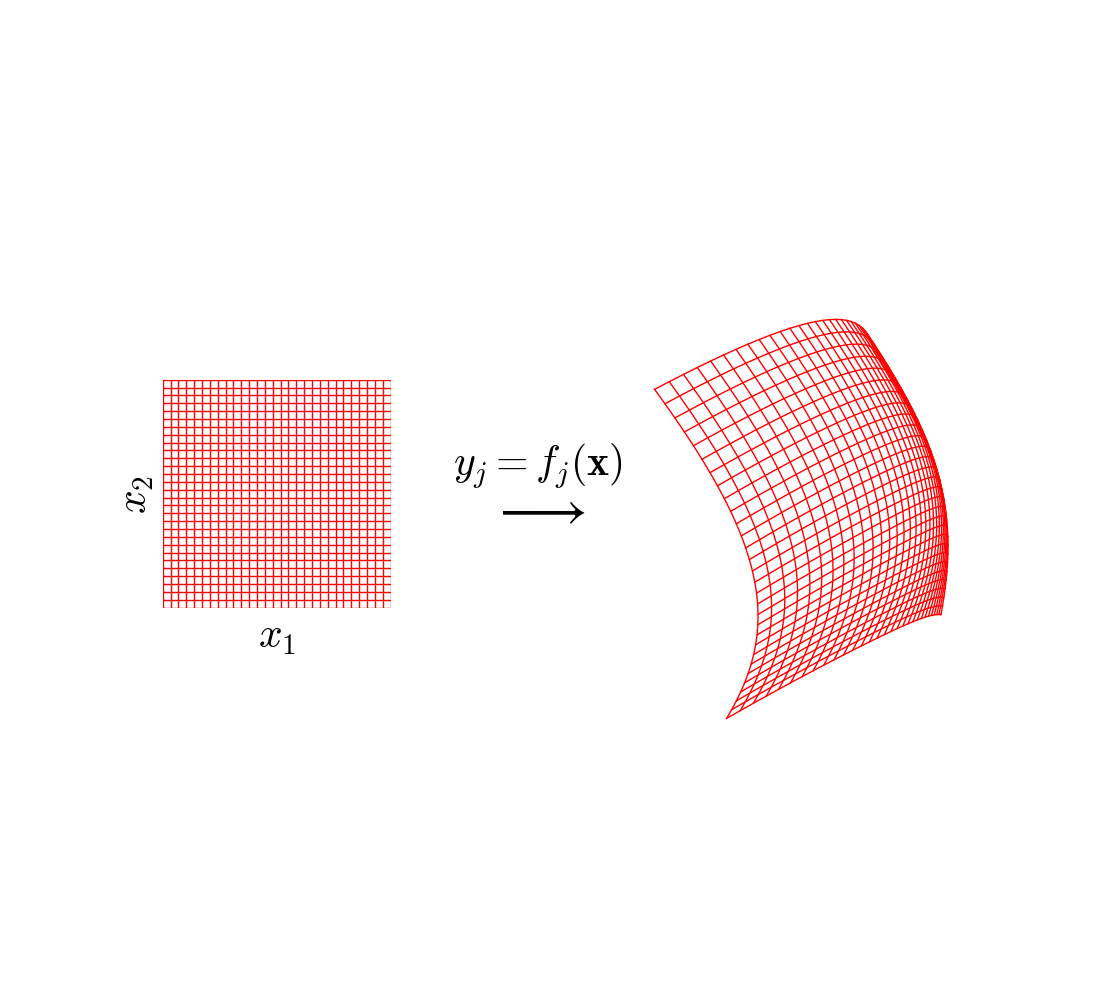

In [5]:
MU = np.column_stack([MU1.flatten(), MU2.flatten()])
num_basis_func = MU.shape[0]
number = X.shape[0]
Phi = np.exp(-dist2(X, MU)/(2*rbf_width*rbf_width))
num_samples = 3
np.random.seed(13)
W = np.random.randn(num_samples, num_basis_func)*np.sqrt(alpha)
F = np.dot(Phi,W.T)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
fig.delaxes(ax[2])
ax[2] = fig.add_subplot(133, projection='3d')

start_val = 0
for i in range(number_across):
      end_val = number_across*(i+1)
      a = ax[0].plot(X[start_val:end_val, 0], X[start_val:end_val, 1], 'r-')
      start_val = end_val

# Reshape X to plot lines in opposite directions
X1 = X1.T
X2 = X2.T
X = np.column_stack([X1.flatten(), X2.flatten()])
start_val = 0
for i in range(number_across):
      end_val = number_across*(i+1)
      a = ax[0].plot(X[start_val:end_val, 0], X[start_val:end_val, 1], 'r-')
      start_val = end_val

ax[0].tick_params(axis='both',          
    which='both', bottom='off', top='off', labelbottom='off',
                  right='off', left='off', labelleft='off') 
ax[0].set(aspect='equal')
clear_axes(ax[0])
ax[0].set_xlabel('$x_1$', ha='center', fontsize=30)
ax[0].set_ylabel('$x_2$', ha='center', fontsize=30)



start_val = 0
for i in range(number_across):
      end_val = number_across*(i+1)
      a = ax[2].plot(F[start_val:end_val, 0], 
                        F[start_val:end_val, 1], 
                        F[start_val:end_val, 2], 
                        'r-')
      start_val = end_val

# Reshape F to plot lines in opposite directions
F1 = np.reshape(F[:, 0], (X1.shape[0], X1.shape[1]),order='F')
F2 = np.reshape(F[:, 1], (X1.shape[0], X1.shape[1]),order='F')
F3 = np.reshape(F[:, 2], (X1.shape[0], X1.shape[1]),order='F')
F = np.column_stack([F1.flatten(), F2.flatten(), F3.flatten()])

start_val = 0
for i in range(number_across):
      end_val = number_across*(i+1)
      if True:
            a = ax[2].plot(F[start_val:end_val, 0], 
                        F[start_val:end_val, 1], 
                        F[start_val:end_val, 2],
                        'r-')
      start_val = end_val

# Treble axis size to increase plot size
fig.delaxes(ax[1])
ax[1] = fig.add_subplot(132)
pos = ax[2].get_position()
scale=2.5
npos = [0, 0,  pos.width*scale, pos.height*scale] 
npos[0] = pos.x0 - 0.5*(npos[2] - pos.width)
npos[1] = pos.y0 - 0.5*(npos[3] - pos.height)
ax[2].set_position(npos)
ax[2].set_axis_off()

# Axis for writing text on plot
ax[1].set(position=[0, 0, 1, 1])
ax[1].set(xlim=[0, 1])
ax[1].set(ylim=[0, 1])
ax[1].set_axis_off()
ax[1].text(0.5, 0.55, '$y_j = f_j(\mathbf{x})$', 
           ha='center',
          fontsize=30)
ax[1].text(0.5, 0.45, '$\longrightarrow$', 
           ha='center',
           fontsize=40)
fig.savefig("../../slides/diagrams/nonlinear-mapping-3d-plot.svg", transparent=True)


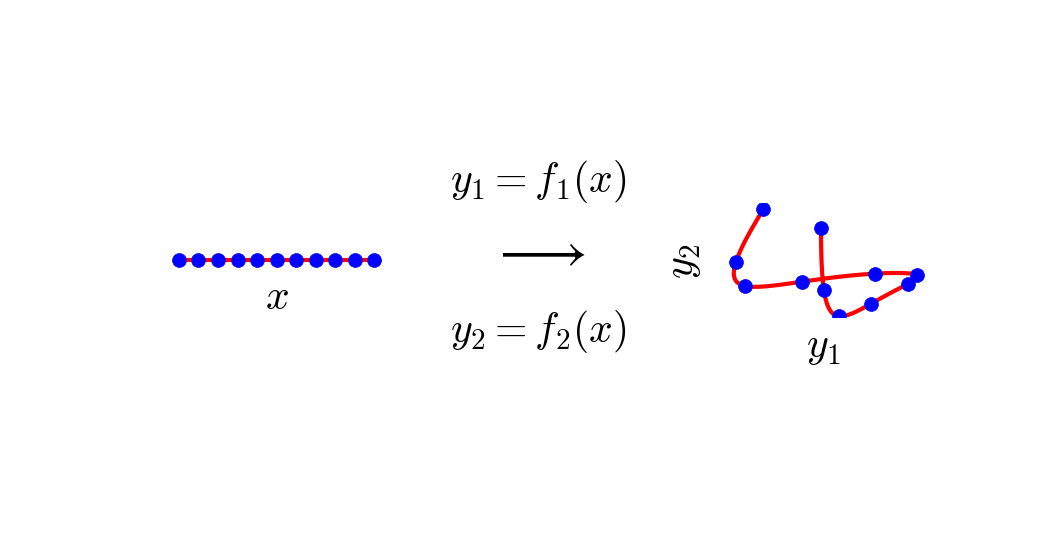

In [6]:
# nonLinearDifficultyPlot2
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for item in ax:
    item.patch.set_visible(False)
    
number_across = 101
x = np.linspace(-6, 6, number_across)[:, None]
num_basis_func = mu.shape[1]
number = x.shape[0]
Phi = np.exp(-dist2(x, mu.T)/(2*rbf_width*rbf_width))
F = np.dot(Phi,W[0:2, 0:num_basis_func].T)

a = ax[0].plot(x, np.ones(x.shape), 'r-');
subx = x[0::10,:]
b = ax[0].plot(subx, np.ones(subx.shape), 'b.')
ax[0].set(ylim=[0.5, 1.5])
ax[0].set(Xlim=[-7, 7])
ax[0].set(aspect='equal')
clear_axes(ax[0])
a[0].set(linewidth=3)
b[0].set(markersize=20)

ax[0].set_xlabel('$x$', ha='center', fontsize=30)

          
          
a = ax[2].plot(F[:, 0], F[:, 1], 'r-')
b = ax[2].plot(F[0::10][:,0], F[0::10][:,1], 'b.')
a[0].set(linewidth=3)
b[0].set(markersize=20)
ax[2].set(aspect='equal')
clear_axes(ax[2])

ax[2].set_xlabel('$y_1$', ha='center', fontsize=30)
ax[2].set_ylabel('$y_2$', ha='center', fontsize=30)

# Axis for writing text on plot
ax[1].set(position=[0, 0, 1, 1])
ax[1].set(xlim=[0, 1])
ax[1].set(ylim=[0, 1])
ax[1].set_axis_off()
ax[1].text(0.5, 0.65, '$y_1 = f_1(x)$', ha='center', fontsize=30)
ax[1].text(0.5, 0.5, '$\longrightarrow$', ha='center', fontsize=40)
ax[1].text(0.5, 0.35, '$y_2 = f_2(x)$', ha='center', fontsize=30)
fig.savefig("../../slides/diagrams/nonlinear-mapping-2d-plot.svg", transparent=True)




NameError: name 'dataStd' is not defined

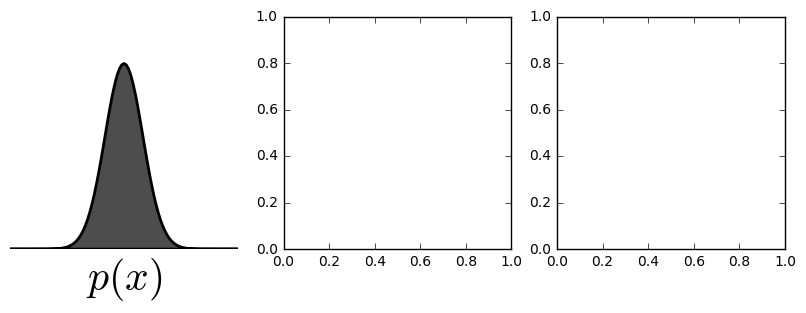

In [7]:
from matplotlib.patches import Polygon
# nonLinearDifficultyPlot3
data_std = 0.2
num_samples = 10000
patch_color=[0.3, 0.3, 0.3]
xsamp = np.random.randn(num_samples, 1)

# Create RBF network with much larger variation in functions.
mu = np.linspace(-4, 4, 100)[None, :]
num_basis_func = mu.shape[1]
rbf_width = 0.1;
Phi = np.exp(-dist2(xsamp, mu.T)/(2*rbf_width*rbf_width))
W = np.random.randn(1, num_basis_func)*np.sqrt(alpha)
f = np.dot(Phi,W.T);

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
p = np.exp(-0.5/alpha*x**2)*1/np.sqrt(2*np.pi*alpha)
patch = Polygon(np.column_stack((x, p)), closed=True, facecolor=patch_color)
a = ax[0].add_patch(patch)
a.set(linewidth=2)

clear_axes(ax[0])
ax[0].set(ylim=[0, 0.5])
ax[0].set(xlim=[-6, 6])
ax[0].set_xlabel('$p(x)$', ha='center', fontsize=30)

y = np.linspace(f.min()-3*data_std, f.max()+3*data_std, 100)[:, None]
p = np.mean(np.exp(-0.5/(data_std*data_std)*dist2(y, f))*1/(np.sqrt(2*np.pi)*data_std), 1)
patch = Polygon(np.column_stack((y, p)), closed=True, facecolor=patch_color)
a=ax[2].add_patch(patch)
a.set(linewidth=2)

clear_axes(ax[2])
ax[2].set(ylim=[0, 0.5])
ax[2].set(xlim=[-6, 6])
ax[2].set_xlabel('$p(y)$', ha='center', fontsize=30)

# Axis for writing text on plot
ax[1].set_position([0, 0, 1, 1])
ax[1].set(xlim=[0, 1])
ax[1].set(ylim=[0, 1])
ax[1].set_axis_off()
ax[1].text(0.5, 0.45, '$y = f(x) + \epsilon$', ha='center', fontsize=30)
ax[1].text(0.5, 0.35, '$\longrightarrow$', ha='center', fontsize=40)
fig.savefig("../../slides/diagrams/gaussian-through-nonlinear.svg", transparent=True)

